<a href="https://colab.research.google.com/github/raymondluk1995/Customer-Lifetime-Value-Model/blob/master/CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install lifetimes

In [7]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
import os 
os.chdir("/content/drive/My Drive/CLV Model")

In [33]:
import pandas as pd 
raw_df = pd.read_csv("/content/drive/My Drive/CLV Model/OnlineRetail.csv",encoding="cp1252")

In [12]:
raw_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


Check the dataframe's size.

In [13]:
raw_df.shape

(541909, 8)

Check any null data properties.

In [14]:
raw_df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Remove data whose CustomerID is null since in CLV customer ID is significant.

In [34]:
raw_df = raw_df.dropna(axis=0,subset=['CustomerID'])

In [18]:
raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [35]:
# Change InvoicdDate to YY-MM-DD
raw_df['InvoiceDate'] = pd.to_datetime(raw_df['InvoiceDate'],format="%m/%d/%Y %H:%M").dt.date
raw_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [41]:
#check illegal quantity
import numpy as np
np.where(raw_df['Quantity']<=0)[0].shape

(8905,)

In [42]:
raw_df = raw_df[(raw_df['Quantity'])>0]
raw_df['Sales'] = raw_df['UnitPrice'] * raw_df['Quantity'] 
# Create an analysis dataframe
ana_df = raw_df[['CustomerID','InvoiceDate','Sales']]
ana_df.head()

,CustomerID,InvoiceDate,Sales
0,17850.0,2010-12-01,15.30
1,17850.0,2010-12-01,20.34
2,17850.0,2010-12-01,22.00
3,17850.0,2010-12-01,20.34
4,17850.0,2010-12-01,20.34


Check the number of unique items

In [43]:
ana_df.nunique()

CustomerID     4339
InvoiceDate     305
Sales          2940
dtype: int64

## CLV Model Construction

### Get Data Summary

- `frequency` represents the number of *repeat* purchases the customer has made. This means that it's one less than the total number of purchases.
- `T` represents the age of the customer in whatever time units chosen (weekly above). This is equal to the duration between a customer's first purchase and the end of the period under study.
- `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [47]:
from lifetimes.plotting import * 
from lifetimes.utils import * 
# Get the latest date 
print(ana_df['InvoiceDate'].max())
latest_date = ana_df['InvoiceDate'].max()

2011-12-09


In [48]:
# lt_df represents lifetime dataframe
lt_df = summary_data_from_transaction_data(ana_df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end=latest_date)

In [49]:
lt_df.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


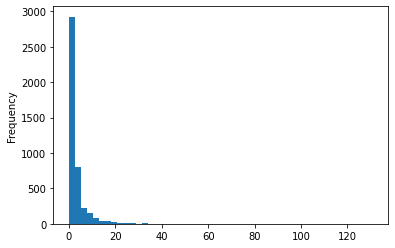

In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
lt_df['frequency'].plot(kind='hist',bins=50)

In [56]:
print(lt_df['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lt_df['frequency'] == 0)/float(len(lt_df))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 35.7 %


### Frequency/Recency Analysis Using the BG/NBD Model

In [57]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0) 
bgf.fit(lt_df['frequency'], lt_df['recency'], lt_df['T'])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [58]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


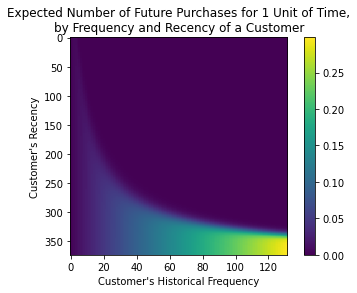

In [59]:
%matplotlib inline 
plot_frequency_recency_matrix(bgf)

It could be seen that both frequency and recency determine the expected number of future purchases. Only if both of them are big enough, the expected number could be positive. However, the expected number seems to be not big enough as the maximum is approximately 0.3. 

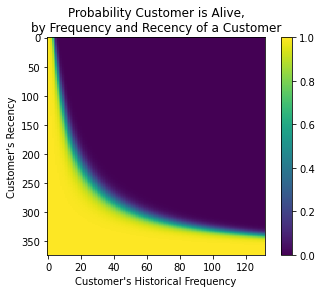

In [61]:
plot_probability_alive_matrix(bgf)

From the plot above it could be seen that the recency determines more in the aliveness probability. Even customer's historical frequency is zero, the customer's aliveness still could be positive.

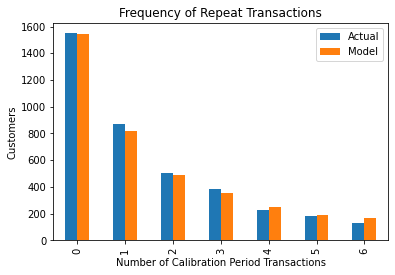

In [67]:
plot_period_transactions(bgf)

The "Number of Calibration Period Transactions" means the transaction frequency within a certain calibration period. And this plot reveals how well the BG model fits the data.

In [68]:
#Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation.
lt_df[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046161
frequency,0.046161,1.000000


It could be seen that the correlation between monetary value and frequency is small.

In [69]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lt_df[lt_df['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   CustomerID  frequency  ...  monetary_value  pred_transaction_times
0     14911.0      131.0  ...     1093.661679                    8.95
1     12748.0      113.0  ...      298.360885                    7.73
2     17841.0      111.0  ...      364.452162                    7.59
3     15311.0       89.0  ...      677.729438                    6.10
4     14606.0       88.0  ...      135.890114                    6.03

[5 rows x 6 columns]
-----------------------------------------
The Number of Returning Customers are:  2790


Now we make a prediction of transaction times in the future 30 days.

In [66]:
future_days = 30 
lt_df['pred_transaction_times'] = round(bgf.predict(future_days,lt_df['frequency'],lt_df['recency'],lt_df['T']),2)
lt_df = lt_df.sort_values(by='pred_transaction_times',ascending=False)
lt_df.head()

,frequency,recency,T,monetary_value,pred_transaction_times
CustomerID,,,,,
14911.0,131.0,372.0,373.0,1093.661679,8.95
12748.0,113.0,373.0,373.0,298.360885,7.73
17841.0,111.0,372.0,373.0,364.452162,7.59
15311.0,89.0,373.0,373.0,677.729438,6.10
14606.0,88.0,372.0,373.0,135.890114,6.03


### Estimate of Shortlist Customer Lifetime Value

In [70]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(shortlisted_customers['frequency'],shortlisted_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [72]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 
print(ggf.conditional_expected_average_profit(
        lt_df['frequency'],
        lt_df['monetary_value']
    ).head(10))

CustomerID
14911.0    1087.698039
12748.0     299.570360
17841.0     364.996941
15311.0     674.360499
14606.0     139.560895
12971.0     163.428864
13089.0     885.321458
14527.0     160.647912
13798.0     700.303827
16422.0     695.567350
dtype: float64


In [73]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        lt_df['frequency'],
        lt_df['monetary_value']
    ).mean(),
    lt_df[lt_df['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 441.1284032747344, Average profit: 477.35868925356596


In [75]:
lt_df['pred_transac_sales'] = round(ggf.conditional_expected_average_profit(
                                    lt_df['frequency'],lt_df['monetary_value']),2)
lt_df.head()

,frequency,recency,T,monetary_value,pred_transaction_times,pred_transac_sales
CustomerID,,,,,,
14911.0,131.0,372.0,373.0,1093.661679,8.95,1087.70
12748.0,113.0,373.0,373.0,298.360885,7.73,299.57
17841.0,111.0,372.0,373.0,364.452162,7.59,365.00
15311.0,89.0,373.0,373.0,677.729438,6.10,674.36
14606.0,88.0,372.0,373.0,135.890114,6.03,139.56


In [77]:
# Calculate the Customer Lifetime Value 
lt_df['CLV'] = round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    lt_df['frequency'],
    lt_df['recency'],
    lt_df['T'],
    lt_df['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)
lt_df.head()

,frequency,recency,T,monetary_value,pred_transaction_times,pred_transac_sales,CLV
CustomerID,,,,,,,
14911.0,131.0,372.0,373.0,1093.661679,8.95,1087.70,109442.13
12748.0,113.0,373.0,373.0,298.360885,7.73,299.57,26026.75
17841.0,111.0,372.0,373.0,364.452162,7.59,365.00,31153.59
15311.0,89.0,373.0,373.0,677.729438,6.10,674.36,46235.47
14606.0,88.0,372.0,373.0,135.890114,6.03,139.56,9461.97
